In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

#### This notebook is used to create the script (& submit the jobs for) mapping the CDS regions from each Reference Genome (downloaded from NCBI) against the CDS regions of H37Rv. The goal is to assess the quality of the mappings across genes on the entire genome to determine which Reference Genomes to use in our simulations.

################################################################################################################################################################################################################################################

## [1] Create the Script to map the CDS regions from a given Reference Genome against the CDS regions of H37Rv 

################################################################################################################################################################################################################################################

In [2]:
#Choose a specific reference genome, pull sequence & annotation; compare to H37Rv (indexed: 0 - 59)
ref_genome_i = 8 #H37Rv (fasta & annotation table) as downloaded from NCBI

In [3]:
#import necessary packages
import vcf
import os
import pandas as pd
import numpy as np

from itertools import compress
import ast
import itertools
import time

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
from Bio import pairwise2
from shutil import copy
import subprocess
import pickle

In [4]:
##########################################################################################
##########################################################################################
'''
This piece of code constructs a mapping of the CDS regions of H37Rv to the CDS 
regions of the chosen reference sequence (ref_genome_i) using the 
feature annotation tables for both sequences.
'''

# check to see if the reference genomes have a corresponding feature annotation table

#annotation for reference sequences
ref_seqs_annot = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/final_table.tsv' ,  sep = '\t')

#directory where annotation files are stored
ref_strain_genome_annot_files_directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/reference_sequence_annotation_tables/'
reference_strain_feature_counts_tables = os.listdir(ref_strain_genome_annot_files_directory)

reference_genome_strain_has_feature_table = []
reference_genome_strain_feature_table_names = []

for reference_genome_strain in ref_seqs_annot.Strain:

    #split the reference id to get back relevant info to find the filename
    genbank , reference_id_1 , reference_id_2 , genomic_word = reference_genome_strain.split('_')
    folder_1 = reference_id_1[0:3]
    folder_2 = reference_id_1[3:6]
    folder_3 = reference_id_1[6:9]
    folder_4 = 'GCF_' + reference_id_1 + '_' + reference_id_2

    reference_strain_annotation_filename = folder_4 + '_feature_table.txt.gz'

    if reference_strain_annotation_filename in reference_strain_feature_counts_tables:
        reference_genome_strain_has_feature_table.append('YES')
        reference_genome_strain_feature_table_names.append(reference_strain_annotation_filename)

    else:
        reference_genome_strain_has_feature_table.append('NO')
        reference_genome_strain_feature_table_names.append('No Table')

ref_seqs_annot.loc[: , 'Has_Feature_Table'] = reference_genome_strain_has_feature_table
ref_seqs_annot.loc[: , 'Feature_Table_filename'] = reference_genome_strain_feature_table_names

#drop strains that don't have a corresponding feature table
ref_seqs_annot = ref_seqs_annot[ref_seqs_annot.Has_Feature_Table == 'YES']
ref_seqs_annot.reset_index(drop = True , inplace = True)

#############################################################################

#PULL H37Rv sequence & annotation information

#H37Rv GENOME SEQUENCE
H37Rv_genome = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv.fasta'
for H37Rv_seq in SeqIO.parse(H37Rv_genome, "fasta"):
    H37Rv_seq.seq.alphabet = IUPAC.unambiguous_dna

#H37Rv REFERENCE ANNOTATION
H37Rv_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

#filter out annotation for t-RNAs and other misc RNAs
RNAs_filter = []
for CDS_i in H37Rv_annotation.index:
    if ('tRNA' in H37Rv_annotation.loc[CDS_i , 'description'].split(' ')) or ('Rvn' in CDS_i):
        RNAs_filter.append(True)
        
    else:
        RNAs_filter.append(False)

non_RNAs_filter = [not RNA for RNA in RNAs_filter]

H37Rv_annotation_no_RNA = H37Rv_annotation[non_RNAs_filter]

#drop unneccessary columns
H37Rv_annotation_no_RNA = H37Rv_annotation_no_RNA.loc[: , ['symbol' , 'length' , 'chromStart' , 'chromEnd' , 'strand' , 'description']]


#STORE CORRESPONDING SEQUENCES FROM H37Rv IN GENOME ANNOTATION
for gene_id in H37Rv_annotation_no_RNA.index:

    start_site = min( (H37Rv_annotation_no_RNA.loc[gene_id , 'chromStart']) , H37Rv_annotation_no_RNA.loc[gene_id , 'chromEnd'] ) #starts counting from 1
    end_site = max( (H37Rv_annotation_no_RNA.loc[gene_id , 'chromStart']) , H37Rv_annotation_no_RNA.loc[gene_id , 'chromEnd'] )

    seq_i = H37Rv_seq.seq[start_site:end_site] 

    #store sequence
    H37Rv_annotation_no_RNA.loc[gene_id , 'sequence'] = seq_i

#############################################################################
#PULL REFERENCE sequence & annotation information

#specify specific reference sequence
ref_genome_strain = list(ref_seqs_annot.Strain)[ref_genome_i]
ref_genome_strain_annotation_filename = list(ref_seqs_annot.Feature_Table_filename)[ref_genome_i]

#directory where the fasta files for the reference sequences are stored
ref_seq_directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/'
#directory where annotation files are stored
ref_strain_genome_annot_files_directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/reference_sequence_annotation_tables/'

#REFERENCE GENOME SEQUENCE
#get full path for the fasta file corrresponding to the reference sequence
ref_genome_fasta = ref_seq_directory + ref_genome_strain  + '.fasta'

#parse the fasta file corresponding to the reference genome
for reference_genome in SeqIO.parse(ref_genome_fasta, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

#REFERENCE GENOME FEATURE TABLE
ref_genome_annot = pd.read_csv(ref_strain_genome_annot_files_directory + ref_genome_strain_annotation_filename , compression = 'gzip' , header = 0 , sep = '\t')

#filter for rows that code for 'genes'
ref_genome_annot = ref_genome_annot[ref_genome_annot.ix[: , 0] == 'gene']

#filter for rows that are 'protein_coding' or 'pseudogene'
protein_coding_or_pseudogene_filter = [protein_coding or pseudogene for protein_coding , pseudogene in zip(list(ref_genome_annot.ix[: , 1] == 'protein_coding') , list(ref_genome_annot.ix[: , 1] == 'pseudogene'))]
ref_genome_annot = ref_genome_annot[protein_coding_or_pseudogene_filter]

#filter out for buggy first rows that contain the start/end of the whole Reference Genome Sequence
ref_genome_annot = ref_genome_annot[ (ref_genome_annot.end - ref_genome_annot.start) < 1000000 ]

#drop unnecessary columns
ref_genome_annot = ref_genome_annot.loc[: , [ 'start' , 'end' , 'strand' , 'symbol' , 'feature_interval_length']]

ref_genome_annot.reset_index(inplace = True , drop = True)

#STORE CORRESPONDING SEQUENCES FROM REFERENCE GENOME IN GENOME ANNOTATION
for CDS_i in ref_genome_annot.index:

    start_site = min( (ref_genome_annot.loc[CDS_i , 'start'] - 1) , ref_genome_annot.loc[CDS_i , 'end'] ) #starts counting from 1
    end_site = max( (ref_genome_annot.loc[CDS_i , 'start'] - 1) , ref_genome_annot.loc[CDS_i , 'end'] )

    seq_i = reference_genome.seq[start_site:end_site] 

    #store sequence
    ref_genome_annot.loc[CDS_i , 'sequence'] = seq_i
    
#############################################################################
#############################################################################

In [5]:
#############################################################################
#############################################################################
'''
This piece of code compares the given Reference Genome with H37Rv & attempts 
to map ALL Relevant Coding Regions between both Reference Genomes for ALL Genes.
'''

#define window size for CDS length comparison (has to be an even number)
window_size = 10

num_genes = len(H37Rv_annotation_no_RNA.index) #number of genes after excluding RNAs

#WRAP AROUND CHROMOSOME FOR FIRST/LAST FEW GENES
#in order to 'wrap around' chromosome, append last 5 genes to beginning of DF and first 5 genes to end of DF to create sliding window for all genes
last_few_genes_annot = H37Rv_annotation_no_RNA.ix[num_genes - (window_size / 2) : , :] #last few genes
first_few_genes_annot = H37Rv_annotation_no_RNA.ix[0 : (window_size / 2) , :] #first few genes
H37Rv_annotation_no_RNA_fudged_for_circular_chrom = last_few_genes_annot.append(H37Rv_annotation_no_RNA.append(first_few_genes_annot))

#H37Rv-ref_genome coding mapping
#create dataframe to hold mapping
H37Rv_RefGeome_gene_mapping = pd.DataFrame(columns = ['symbol' , 'H37Rv_start' , 'H37Rv_end' , 'RefGenome_start' , 'RefGenome_end' , 'strand' , 'Highest_window_score' , 'second_Highest_window_score' , 'window_index'])

#look across all genes in H37Rv
all_genes = (H37Rv_annotation_no_RNA_fudged_for_circular_chrom.index) 

for gene_id in all_genes[ (window_size / 2) : - (window_size / 2) ]: #skip first several rows & last several rows (which are redundant genes created for sliding windows) 

    #find index in H37Rv annotation dataframe
    row_index = list(H37Rv_annotation_no_RNA_fudged_for_circular_chrom.ix[(window_size / 2) : - (window_size / 2)].index).index(gene_id) + 5

    #take the 5 CDS regions before & after into account
    H37Rv_annotation_no_RNA_neighborhood = H37Rv_annotation_no_RNA_fudged_for_circular_chrom.ix[ row_index - (window_size / 2) : row_index + ((window_size / 2) + 1) , :]
    
    #look at gene lengths of the 11 consective genes & look for similar gene length profile in reference genome
    H37Rv_annotation_no_RNA_neighborhood_lengths = H37Rv_annotation_no_RNA_neighborhood.length

    #compare the neighborhood of gene lengths with every set of consecutive 11 gene lengths in reference genome annotation
    ## key: window_index , value: score of gene_length_window_match
    gene_length_match_scores = {}

    #create a sliding window of gene lengths to find the appropriate coding region on the reference genome for novel genes
    first_window_index = window_size / 2
    last_window_index = np.shape(ref_genome_annot)[0] - (window_size / 2)

    for gene_lengths_window_i in range(first_window_index , last_window_index):

        #take the 5 CDS regions before & after into account
        ref_genome_annot_neighborhood = ref_genome_annot.ix[ gene_lengths_window_i - (window_size / 2) : gene_lengths_window_i + (window_size / 2) , :]

        #look at gene lengths of the 11 consecutive genes & look for similar gene length profile in H37Rv
        ref_genome_annot_neighborhood_lengths =  ref_genome_annot_neighborhood.feature_interval_length
        
        #compare window of gene lengths between reference genome and H37Rv
        length_match_score = len( set(list(ref_genome_annot_neighborhood_lengths)).intersection(set(list(H37Rv_annotation_no_RNA_neighborhood_lengths))) ) #rough match method

        #store window index and corresponding match score
        gene_length_match_scores[gene_lengths_window_i] = length_match_score

    #find the max match score and corresponding window index
    gene_length_match_scores = pd.Series(gene_length_match_scores)
    
    gene_length_match_scores_genome_order = gene_length_match_scores
    
    gene_length_match_scores = gene_length_match_scores.sort_values(ascending = False)
    
    window_index_top_match_score = list(gene_length_match_scores)[0] #top score for sliding window alignments
    
    #store window indice(s) that have the top match score
    window_indices_with_top_score = list(gene_length_match_scores[gene_length_match_scores == window_index_top_match_score].index)
    
    gene_alignment_scores_in_top_window = {} #key: sub-window indices , valus: score from pariwise alignment
    
    #iterate through all highest scoring windows (or neighborhoods)
    for window_match_index in window_indices_with_top_score:
        
        #align gene_i to every CDS within the 'sliding window' of the highest window scoring CDS region(s)
        first_chosen_window_index = window_match_index - (window_size / 2)
        last_chosen_window_index = window_match_index + (window_size / 2)

        for window_index in range(first_chosen_window_index , last_chosen_window_index + 1):

            #find the gene sequence corresponding to window index
            corresponding_gene_ref_genome = ref_genome_annot.loc[window_index , :]

            #check to see if sequences are identical by aligning them
            H37Rv_coding_seq = H37Rv_annotation_no_RNA.loc[gene_id , 'sequence']
            ref_genome_coding_seq = corresponding_gene_ref_genome.sequence

            #Identical characters are given 1 point, -1/2 point is deducted for each non-identical character, 2 points are deduced when opening a gap, 2 point is deducted for extending it
            alignment_score = pairwise2.align.globalms(H37Rv_coding_seq, ref_genome_coding_seq , 2 , -1 , -2 , -2 , score_only = True)

            #store in dictionary
            gene_alignment_scores_in_top_window[window_index] = alignment_score
            
    #choose window index with highest alignment score as match (this time from genes within top/chosen window)
    top_window_score_gene_alignments_results = pd.Series(gene_alignment_scores_in_top_window)
    top_window_score_gene_alignments_results = top_window_score_gene_alignments_results.sort_values(ascending = False)
    
    window_match_index = list(top_window_score_gene_alignments_results.index)[0] #take the index corresponding to the top alignment score
    window_match_score = list(top_window_score_gene_alignments_results)[0] #actual raw score from top alignment
    
    #store relevant information
    corresponding_gene_ref_genome = ref_genome_annot.loc[window_match_index , :]
    
    H37Rv_gene_length = H37Rv_annotation_no_RNA.loc[gene_id , 'length']
    RefGenome_gene_length = corresponding_gene_ref_genome.feature_interval_length
    
    #if window match score positive and gene lengths match, then likely a correct match also ensure 'found' gene has same length as gene in H37Rv
    if (window_match_score > 0) and (H37Rv_gene_length == RefGenome_gene_length): 

        symbol = H37Rv_annotation_no_RNA.loc[gene_id , 'symbol']
        strand = H37Rv_annotation_no_RNA.loc[gene_id , 'strand']
        H37Rv_start = H37Rv_annotation_no_RNA.loc[gene_id , 'chromStart']
        H37Rv_end = H37Rv_annotation_no_RNA.loc[gene_id , 'chromEnd']
        RefGenome_start = corresponding_gene_ref_genome.start
        RefGenome_end = corresponding_gene_ref_genome.end

        Highest_window_score = list(gene_length_match_scores)[0]
        second_Highest_window_score = list(gene_length_match_scores)[1]

        #start counting from 0!
        H37Rv_RefGeome_gene_mapping.loc[gene_id , :] = [symbol , H37Rv_start , H37Rv_end , RefGenome_start - 1 , RefGenome_end , strand , Highest_window_score , second_Highest_window_score , window_match_index]
        
    else: #if window match score negative, then likely no gene/CDS analogue was found
        
        H37Rv_RefGeome_gene_mapping.loc[gene_id , :] = [np.nan]*9
    
##########################################################################################
##########################################################################################

In [ ]:
##########################################################################################
##########################################################################################
'''
This piece of code stores all of the Mappings in a CSV file.
'''

#calculate the differences between the highest score and the second highest score
H37Rv_RefGeome_gene_mapping['Score_Diff'] =  H37Rv_RefGeome_gene_mapping.Highest_window_score - H37Rv_RefGeome_gene_mapping.second_Highest_window_score

#save output file
directory_for_tables = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/genome_plasticity_window_analysis_csv_files_10_gene_windows_rough_match/'
H37Rv_RefGeome_gene_mapping.to_csv(directory_for_tables + ref_genome_strain + '_H37Rv_mapping_window_analysis.csv' , sep = ',')

##########################################################################################
##########################################################################################

################################################################################################################################################################################################################################################

## [2] Submit the above as a job for each seperate Reference Genome

################################################################################################################################################################################################################################################

In [2]:
from slurmpy import Slurm
import os
import pandas as pd
import numpy as np

In [3]:
#Choose a specific reference genome, pull sequence & annotation; compare to H37Rv (indexed: 0 - 59)
for ref_genome_i in range(0 , 60):

    ref_genome_i = str(ref_genome_i)

    #command to run script
    run_script = "python /n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/python_scripts/Mtb_RefGenome_H37Rv_gene_mapping_and_window_analysis_rough_match.py " + ref_genome_i

    #submit job to O2
    #directory where you want output + error files
    os.chdir("/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/O2_jobs_output/Mtb_RefGenome_H37Rv_mapping_and_window_analysis")

    #submit job to O2
    job_name = ref_genome_i

    s = Slurm(job_name , {'partition':'short' , 'n':'1' , 't':'0-12:00:00' , 'mem-per-cpu':'8G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(run_script)

    print job_name  + ' : ' +  str(job_id)

submitted: Submitted batch job 2968686
submitted: Submitted batch job 2968688
submitted: Submitted batch job 2968689


0 : 2968686
1 : 2968688
2 : 2968689


submitted: Submitted batch job 2968690


3 : 2968690


submitted: Submitted batch job 2968693


4 : 2968693


submitted: Submitted batch job 2968694


5 : 2968694


submitted: Submitted batch job 2968696
submitted: Submitted batch job 2968697


6 : 2968696
7 : 2968697


submitted: Submitted batch job 2968699


8 : 2968699


submitted: Submitted batch job 2968700
submitted: Submitted batch job 2968701
submitted: Submitted batch job 2968702
submitted: Submitted batch job 2968703


9 : 2968700
10 : 2968701
11 : 2968702
12 : 2968703


submitted: Submitted batch job 2968704


13 : 2968704


submitted: Submitted batch job 2968706


14 : 2968706


submitted: Submitted batch job 2968707


15 : 2968707


submitted: Submitted batch job 2968708
submitted: Submitted batch job 2968710
submitted: Submitted batch job 2968711


16 : 2968708
17 : 2968710
18 : 2968711


submitted: Submitted batch job 2968712


19 : 2968712


submitted: Submitted batch job 2968714


20 : 2968714


submitted: Submitted batch job 2968715


21 : 2968715


submitted: Submitted batch job 2968717
submitted: Submitted batch job 2968718
submitted: Submitted batch job 2968719
submitted: Submitted batch job 2968720
submitted: Submitted batch job 2968721


22 : 2968717
23 : 2968718
24 : 2968719
25 : 2968720
26 : 2968721


submitted: Submitted batch job 2968724
submitted: Submitted batch job 2968725


27 : 2968724
28 : 2968725


submitted: Submitted batch job 2968726
submitted: Submitted batch job 2968727
submitted: Submitted batch job 2968728
submitted: Submitted batch job 2968729
submitted: Submitted batch job 2968730


29 : 2968726
30 : 2968727
31 : 2968728
32 : 2968729
33 : 2968730


submitted: Submitted batch job 2968731
submitted: Submitted batch job 2968733


34 : 2968731
35 : 2968733


submitted: Submitted batch job 2968734
submitted: Submitted batch job 2968735
submitted: Submitted batch job 2968736
submitted: Submitted batch job 2968737
submitted: Submitted batch job 2968738


36 : 2968734
37 : 2968735
38 : 2968736
39 : 2968737
40 : 2968738


submitted: Submitted batch job 2968739
submitted: Submitted batch job 2968740
submitted: Submitted batch job 2968742
submitted: Submitted batch job 2968743


41 : 2968739
42 : 2968740
43 : 2968742
44 : 2968743


submitted: Submitted batch job 2968744
submitted: Submitted batch job 2968745
submitted: Submitted batch job 2968746
submitted: Submitted batch job 2968747


45 : 2968744
46 : 2968745
47 : 2968746
48 : 2968747


submitted: Submitted batch job 2968749
submitted: Submitted batch job 2968750
submitted: Submitted batch job 2968751
submitted: Submitted batch job 2968752
submitted: Submitted batch job 2968753


49 : 2968749
50 : 2968750
51 : 2968751
52 : 2968752
53 : 2968753


submitted: Submitted batch job 2968754
submitted: Submitted batch job 2968755
submitted: Submitted batch job 2968756
submitted: Submitted batch job 2968757


54 : 2968754
55 : 2968755
56 : 2968756
57 : 2968757


submitted: Submitted batch job 2968758


58 : 2968758
59 : 2968760


submitted: Submitted batch job 2968760


################################################################################################################################################################################################################################################

## [3] Analyze the output (CSV files) from the jobs above

################################################################################################################################################################################################################################################

In [4]:
#import necessary packages
import vcf
import os
import pandas as pd
import numpy as np

from itertools import compress
import ast
import itertools

import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
from Bio import pairwise2
from shutil import copy
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns
import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
import matplotlib as mpl

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Retrieve a Table of the Reference Genomes that had Corresponding Feature Annotation Tables and were Mapped to H37Rv

In [5]:
# check to see if the reference genomes have a corresponding feature annotation table

#annotation for reference sequences
ref_seqs_annot = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/final_table.tsv' ,  sep = '\t')

#directory where annotation files are stored
ref_strain_genome_annot_files_directory = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/reference_sequence_annotation_tables/'
reference_strain_feature_counts_tables = os.listdir(ref_strain_genome_annot_files_directory)

reference_genome_strain_has_feature_table = []
reference_genome_strain_feature_table_names = []

for reference_genome_strain in ref_seqs_annot.Strain:

    #split the reference id to get back relevant info to find the filename
    genbank , reference_id_1 , reference_id_2 , genomic_word = reference_genome_strain.split('_')
    folder_1 = reference_id_1[0:3]
    folder_2 = reference_id_1[3:6]
    folder_3 = reference_id_1[6:9]
    folder_4 = 'GCF_' + reference_id_1 + '_' + reference_id_2

    reference_strain_annotation_filename = folder_4 + '_feature_table.txt.gz'

    if reference_strain_annotation_filename in reference_strain_feature_counts_tables:
        reference_genome_strain_has_feature_table.append('YES')
        reference_genome_strain_feature_table_names.append(reference_strain_annotation_filename)

    else:
        reference_genome_strain_has_feature_table.append('NO')
        reference_genome_strain_feature_table_names.append('No Table')

ref_seqs_annot.loc[: , 'Has_Feature_Table'] = reference_genome_strain_has_feature_table
ref_seqs_annot.loc[: , 'Feature_Table_filename'] = reference_genome_strain_feature_table_names

#drop strains that don't have a corresponding feature table
ref_seqs_annot = ref_seqs_annot[ref_seqs_annot.Has_Feature_Table == 'YES']
ref_seqs_annot.reset_index(drop = True , inplace = True)

In [6]:
ref_seqs_annot.head()

,Strain,Decision,Evaluation,Strain name,Has_Feature_Table,Feature_Table_filename
0,GCA_000008585.1_ASM858v1_genomic,"lineage4,lineage4.1,lineage4.1.1,lineage4.1.1.3",4,CDC1551,YES,GCF_000008585.1_ASM858v1_feature_table.txt.gz
1,GCA_000016145.1_ASM1614v1_genomic,"lineage4,lineage4.9",4,H37Ra,YES,GCF_000016145.1_ASM1614v1_feature_table.txt.gz
2,GCA_000016925.1_ASM1692v1_genomic,"lineage4,lineage4.3,lineage4.3.2,lineage4.3.2.1",4,F11,YES,GCF_000016925.1_ASM1692v1_feature_table.txt.gz
3,GCA_000023625.1_ASM2362v1_genomic,"lineage4,lineage4.3,lineage4.3.3",4,KZN 1435,YES,GCF_000023625.1_ASM2362v1_feature_table.txt.gz
4,GCA_000153685.2_ASM15368v2_genomic,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",4,str. Haarlem,YES,GCF_000153685.2_ASM15368v2_feature_table.txt.gz


### Store the Mapping DF for each RefGenome

In [7]:
#directory where CSV files are stored (1 for each RefGenome)
directory_for_tables = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/genome_plasticity_window_analysis_csv_files_10_gene_windows_rough_match/'
os.chdir(directory_for_tables)

#get list of all CSV file names
RefGenome_map_filenames = os.listdir(directory_for_tables)

In [8]:
RefGenome_Mappings_DF_dict = {}

for RefGenome_Mapping in RefGenome_map_filenames:
    
    RefGenome_ID = RefGenome_Mapping.split('_genomic_')[0]
    
    RefGenome_Mapping_sliding_window_info = pd.read_csv(directory_for_tables + RefGenome_Mapping).set_index('Unnamed: 0')

    RefGenome_Mappings_DF_dict[RefGenome_ID] = RefGenome_Mapping_sliding_window_info

In [9]:
RefGenome_Mapping_sliding_window_info.head() #example of mapping for 1 of the Reference Genomes

,symbol,H37Rv_start,H37Rv_end,RefGenome_start,RefGenome_end,strand,Highest_window_score,second_Highest_window_score,window_index,Score_Diff
Unnamed: 0,,,,,,,,,,
Rv0001,dnaA,0.0,1524.0,0.0,1524.0,+,6.0,5.0,0.0,1.0
Rv0002,dnaN,2051.0,3260.0,2051.0,3260.0,+,7.0,6.0,1.0,1.0
Rv0003,recF,3279.0,4437.0,3279.0,4437.0,+,8.0,7.0,2.0,1.0
Rv0004,NaN,4433.0,4997.0,4433.0,4997.0,+,9.0,8.0,3.0,1.0
Rv0005,gyrB,5239.0,7267.0,5239.0,7267.0,+,10.0,9.0,4.0,1.0


In [10]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='white'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '0.85'

### Calculate the abolute difference between the Starting Positions for all of the Mapped Genes between each Reference Genome and H37Rv to asses the well the genes mapped to eachother.

#### Given the clonality of TB, the genes that end up being mapped between a given Reference Genome and H37Rv should end up being in the same neighborhood with respect to both genomes. We look to see how 'far', on average, genes mapped from H37Rv to the Reference Genome to give us an indication if there were any problematic Reference Genomes that were full of bad mappings.

In [11]:
#create dictionary to store Average Absolute Difference in Gene Mapping Starting Positions
ALL_RefGenome_Avg_StartPos_Diffs = {} #keys: Reference Genome , #values: absolute difference in starting values for gene mappings

for RefGenome_ID in RefGenome_Mappings_DF_dict.keys():
    
    #for a specific Reference Genome, get the absolute difference for all of the gene-gene mappings between the Reference Genome & H37Rv
    RefGenome_H37Rv_Mapping_StartPos_Diffs = abs( RefGenome_Mappings_DF_dict[RefGenome_ID].H37Rv_start.values - RefGenome_Mappings_DF_dict[RefGenome_ID].RefGenome_start.values )
    
    #store the average of these differences (ignoring Nan values which are placeholders for unnsuccessfully mapped genes)
    ALL_RefGenome_Avg_StartPos_Diffs[RefGenome_ID] = np.nanmean( RefGenome_H37Rv_Mapping_StartPos_Diffs )

ALL_RefGenome_Avg_StartPos_Diffs = pd.Series(ALL_RefGenome_Avg_StartPos_Diffs , name = 'RefGenome')  
ALL_RefGenome_Avg_StartPos_Diffs.sort_values(ascending = True , inplace = True)

#convert to DataFrame
ALL_RefGenome_Avg_StartPos_Diffs_DF = pd.DataFrame()
ALL_RefGenome_Avg_StartPos_Diffs_DF['avg_StartPos_diff'] = ALL_RefGenome_Avg_StartPos_Diffs
ALL_RefGenome_Avg_StartPos_Diffs_DF['index_num'] = range(1 , len(ALL_RefGenome_Avg_StartPos_Diffs)+1 )

In [12]:
ALL_RefGenome_Avg_StartPos_Diffs_DF.head(n=60)

,avg_StartPos_diff,index_num
GCA_000195955.2_ASM19595v2,3.222193e+00,1
GCA_001922485.1_ASM192248v1,1.590713e+01,2
GCA_000738475.1_ASM73847v1,1.799506e+01,3
GCA_000738445.1_ASM73844v1,2.142289e+01,4
GCA_000277735.2_ASM27773v2,3.375160e+01,5
GCA_000364825.1_ASM36482v1,2.034171e+02,6
GCA_000827085.1_ASM82708v1,3.409074e+02,7
GCA_001545015.1_ASM154501v1,3.639588e+03,8
GCA_000400615.1_ASM40061v1,4.103268e+03,9
GCA_000786505.1_MT49-02,4.196670e+03,10


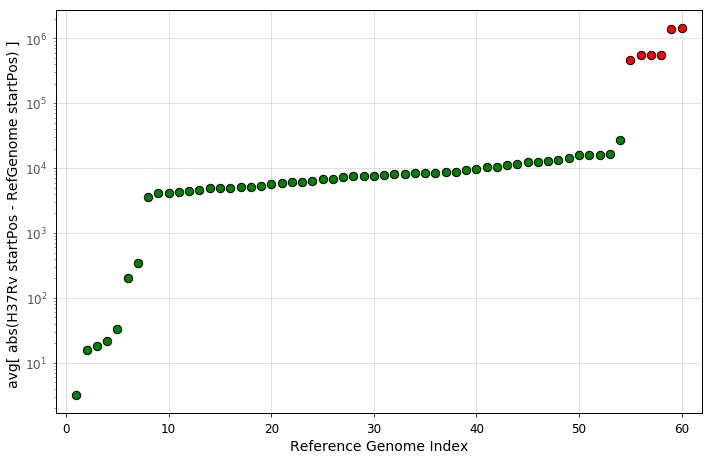

In [13]:
fig , ax = plt.subplots()

#plot good Reference Genomes
plt.scatter( ALL_RefGenome_Avg_StartPos_Diffs_DF[ALL_RefGenome_Avg_StartPos_Diffs_DF.avg_StartPos_diff < 50000].index_num , ALL_RefGenome_Avg_StartPos_Diffs_DF[ALL_RefGenome_Avg_StartPos_Diffs_DF.avg_StartPos_diff < 50000].avg_StartPos_diff , color = 'green' , edgecolor = 'k' , linewidth = 1.0 , s = 70)

#plot bad reference Genomes
plt.scatter( ALL_RefGenome_Avg_StartPos_Diffs_DF[ALL_RefGenome_Avg_StartPos_Diffs_DF.avg_StartPos_diff >= 50000].index_num , ALL_RefGenome_Avg_StartPos_Diffs_DF[ALL_RefGenome_Avg_StartPos_Diffs_DF.avg_StartPos_diff >= 50000].avg_StartPos_diff , color = 'red' , edgecolor = 'k' , linewidth = 1.0 , s = 70)

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax.tick_params(axis='y', which='major', labelsize=12 , pad = 5)
ax.tick_params(axis='x', which='major', labelsize=12 , pad = 5)

ax.set_xlim([-1 , 62])

plt.ylabel('avg[ abs(H37Rv startPos - RefGenome startPos) ] ' , color = 'k' , fontsize = 14)
plt.xlabel('Reference Genome Index' , color = 'k' , fontsize = 14)
ax.set_yscale("log", nonposy='clip')

fig = plt.gcf()
fig.set_size_inches(10, 6.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/SNP_recall_simulations/H37Rv_RefGenome_StartPos_diffs_mapping_quality.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Drop Reference Genomes that mapped badly across the entire genome from use in simulations

In [14]:
ref_seqs_annot.head(n=2) #all Reference Genomes that have a Feature Table

,Strain,Decision,Evaluation,Strain name,Has_Feature_Table,Feature_Table_filename
0,GCA_000008585.1_ASM858v1_genomic,"lineage4,lineage4.1,lineage4.1.1,lineage4.1.1.3",4,CDC1551,YES,GCF_000008585.1_ASM858v1_feature_table.txt.gz
1,GCA_000016145.1_ASM1614v1_genomic,"lineage4,lineage4.9",4,H37Ra,YES,GCF_000016145.1_ASM1614v1_feature_table.txt.gz


In [15]:
np.shape(ref_seqs_annot)

(60, 6)

In [16]:
Bad_RefGenome_IDs = list( ALL_RefGenome_Avg_StartPos_Diffs_DF[ALL_RefGenome_Avg_StartPos_Diffs_DF.avg_StartPos_diff >= 50000].index )

In [17]:
Bad_RefGenome_IDs

['GCA_000193185.2_ASM19318v2',
 'GCA_000023625.1_ASM2362v1',
 'GCA_000154605.2_ASM15460v2',
 'GCA_000154585.2_ASM15458v2',
 'GCA_001750865.1_ASM175086v1',
 'GCA_001870145.1_ASM187014v1']

In [18]:
Ref_Genome_indices_to_Drop = [] #store the index of each Badly Mapped Reference Genome

for RefGenome_i in ref_seqs_annot.index:
    
    if ref_seqs_annot.loc[RefGenome_i , 'Strain'].split('_genomic')[0] in Bad_RefGenome_IDs:
        
        Ref_Genome_indices_to_Drop.append(RefGenome_i)
    
#drop Bad Indices from Table
ref_seqs_annot_for_sims = ref_seqs_annot.drop(Ref_Genome_indices_to_Drop , axis = 0)

#reset index
ref_seqs_annot_for_sims.reset_index(inplace = True , drop = True)

#drop unneccessary column
ref_seqs_annot_for_sims.drop('Has_Feature_Table' , axis = 1 , inplace = True)

In [19]:
ref_seqs_annot_for_sims.head()

,Strain,Decision,Evaluation,Strain name,Feature_Table_filename
0,GCA_000008585.1_ASM858v1_genomic,"lineage4,lineage4.1,lineage4.1.1,lineage4.1.1.3",4,CDC1551,GCF_000008585.1_ASM858v1_feature_table.txt.gz
1,GCA_000016145.1_ASM1614v1_genomic,"lineage4,lineage4.9",4,H37Ra,GCF_000016145.1_ASM1614v1_feature_table.txt.gz
2,GCA_000016925.1_ASM1692v1_genomic,"lineage4,lineage4.3,lineage4.3.2,lineage4.3.2.1",4,F11,GCF_000016925.1_ASM1692v1_feature_table.txt.gz
3,GCA_000153685.2_ASM15368v2_genomic,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",4,str. Haarlem,GCF_000153685.2_ASM15368v2_feature_table.txt.gz
4,GCA_000195955.2_ASM19595v2_genomic,"lineage4,lineage4.9",4,H37Rv complete genome,GCF_000195955.2_ASM19595v2_feature_table.txt.gz


In [20]:
np.shape(ref_seqs_annot_for_sims)

(54, 5)

#### There are 54 Good Reference Genomes (we'll use these in our simulations)

In [21]:
#save Reference Genomes Table (each Reference Genome has a feature annotation table & was mapped well against H37Rv)
ref_seqs_annot_for_sims.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/Reference_Genomes_used_in_simulations.csv')

################################################################################################################################################################################################################################################

## [4] Package the Complete Genome > H37Rv Mappings for sharing

################################################################################################################################################################################################################################################

In [22]:
#import necessary packages
import vcf
import os
import pandas as pd
import numpy as np

from itertools import compress
import ast
import itertools

import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
from Bio import pairwise2
from shutil import copy
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns
import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
import matplotlib as mpl

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Load list of genomes (that were well mapped) that we used in the simulations

In [23]:
ref_seqs_annot_for_sims = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/Reference_Genomes_used_in_simulations.csv').set_index('Unnamed: 0')

In [24]:
ref_seqs_annot_for_sims.head()

,Strain,Decision,Evaluation,Strain name,Feature_Table_filename
Unnamed: 0,,,,,
0,GCA_000008585.1_ASM858v1_genomic,"lineage4,lineage4.1,lineage4.1.1,lineage4.1.1.3",4,CDC1551,GCF_000008585.1_ASM858v1_feature_table.txt.gz
1,GCA_000016145.1_ASM1614v1_genomic,"lineage4,lineage4.9",4,H37Ra,GCF_000016145.1_ASM1614v1_feature_table.txt.gz
2,GCA_000016925.1_ASM1692v1_genomic,"lineage4,lineage4.3,lineage4.3.2,lineage4.3.2.1",4,F11,GCF_000016925.1_ASM1692v1_feature_table.txt.gz
3,GCA_000153685.2_ASM15368v2_genomic,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",4,str. Haarlem,GCF_000153685.2_ASM15368v2_feature_table.txt.gz
4,GCA_000195955.2_ASM19595v2_genomic,"lineage4,lineage4.9",4,H37Rv complete genome,GCF_000195955.2_ASM19595v2_feature_table.txt.gz


In [25]:
np.shape(ref_seqs_annot_for_sims)

(54, 5)

In [26]:
for strain_i in ref_seqs_annot_for_sims.index:
    
    #load mappings from simulations
    complete_genome_H37Rv_mapping_table_i = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/genome_plasticity_window_analysis_csv_files_10_gene_windows_rough_match/{0}_H37Rv_mapping_window_analysis.csv'.format(ref_seqs_annot_for_sims.loc[strain_i , 'Strain']))

    #clean table by dropping unneccessary columns
    complete_genome_H37Rv_mapping_table_i = complete_genome_H37Rv_mapping_table_i.loc[: , ['Unnamed: 0' , 'symbol' , 'H37Rv_start' , 'H37Rv_end' , 'RefGenome_start' , 'RefGenome_end' , 'strand']]

    #rename columns
    complete_genome_H37Rv_mapping_table_i.rename(columns={"Unnamed: 0": "H37Rv Tag" , "RefGenome_start": "CompleteGenome_start" , "RefGenome_end": "CompleteGenome_end"} , inplace = True)

    #set index to H37Rv locus tag
    complete_genome_H37Rv_mapping_table_i.set_index('H37Rv Tag' , inplace = True , drop = True)

    #output to directory with cleaned tables
    complete_genome_H37Rv_mapping_table_i.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/simulated_reads/reference_sequences/strains_typed/genome_plasticity_window_analysis_csv_files_10_gene_windows_rough_match_cleaned_tables/{0}_H37Rv_mappings.csv'.format(ref_seqs_annot_for_sims.loc[strain_i , 'Strain']))